## Sorter Song

In [1]:
SCOPETYPE = 'CWNANO'
PLATFORM = 'CWNANO'

In [2]:
%run "/home/dakshina/projects/csaw_esc_2025/challenges/setup/Setup_Generic.ipynb"
scope.adc.samples = 5000

INFO: Found ChipWhisperer😍


In [3]:
cw.program_target(scope, prog, "sortersSong-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 14551 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 14551 bytes


# Sorters Song 1

## Capturing Power Traces

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
import string
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

# Number of power traces
num_traces = 256

# Define an array to store all the power traces
power_traces = []

target.simpleserial_write('x', b'')
resp = target.simpleserial_read('r', 1)
if resp is not None:
    print("x: ", resp)
    
num = 1
pos=1
target.simpleserial_write('p', bytearray([1, num&0xff, 0, pos]))
resp = target.simpleserial_read('r', 2)
if resp is not None:
    print("p: ", int.from_bytes(resp, byteorder='little', signed=False))
    
target.simpleserial_write('c', b'')
resp = target.simpleserial_read('r', 1)
if resp is not None:
    print("c: ", resp)


power_traces = []
plaintexts = []

for i in range (0,num_traces):

    # Define array with 15 random unit8 values
    # plaintext = np.random.randint(0, 256, size=15, dtype=np.uint8).tolist()
    plaintext = [i] * 15
    print("Plaintext:", plaintext)

    # Arm the Chipwhisper
    scope.arm()

    target.simpleserial_write('a', bytearray(plaintext))

    # Capture the power trace
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')

    resp = target.simpleserial_read('r', 20)
    if resp is not None:
        print("a: ", resp)

    # Read the power trace from the ChipWhisperer Nano
    power_trace = scope.get_last_trace()

    # Append the power trace to the list of power traces
    power_traces.append(power_trace)

# Store power traces and plaintexts in a .npz file
np.savez('power_traces_and_plaintexts.npz', power_traces=np.array(power_traces), plaintexts=np.array(plaintexts))



## Analyzing captured power traces

✅ Data loaded successfully from 'power_traces_and_plaintexts.npz'.
Found 256 traces to visualize.
Original indices in sorted order: [  7  12  43  52  57  66  80 104 113 124 136 147 172 177 219   0   8   2
  16  64   4 128   1  32  24   9  17  33  10  40  65  36  34  48   3  20
 129   5 130 144   6  96  18  72 132  68  13 192  37 160  56  26  11  14
  49  42  73  21 137  88  44  28  35  22  25  41  38  67  81 145  19  69
 140  97  50 161 148 176 133 131  98 152  82  84 112 164 100 168 200  74
 146  70 196 193  76  45 208 162  39  46  15 138  53  27  89 105  75  30
 194  51  90 134  29  23 224  99 106  60 169 101 154 165  54 142  58 170
  71  92 114 201 108 153 163 184 139 209 141 156  85 166  86 102  78 116
 180 150 202 149 120  47 197  77 198  59 216 204  83 210 121 178 225 232
 212 135  62  55  31 109 240  79 122 228 195  93 143 171  94  91 226 107
  61 110 155 173 157 185 117 151  87 167 103 158 217 188 179 186 181 218
 174  63 206 203 233 248 220 229  95 205 199 115 211 123 111 236 

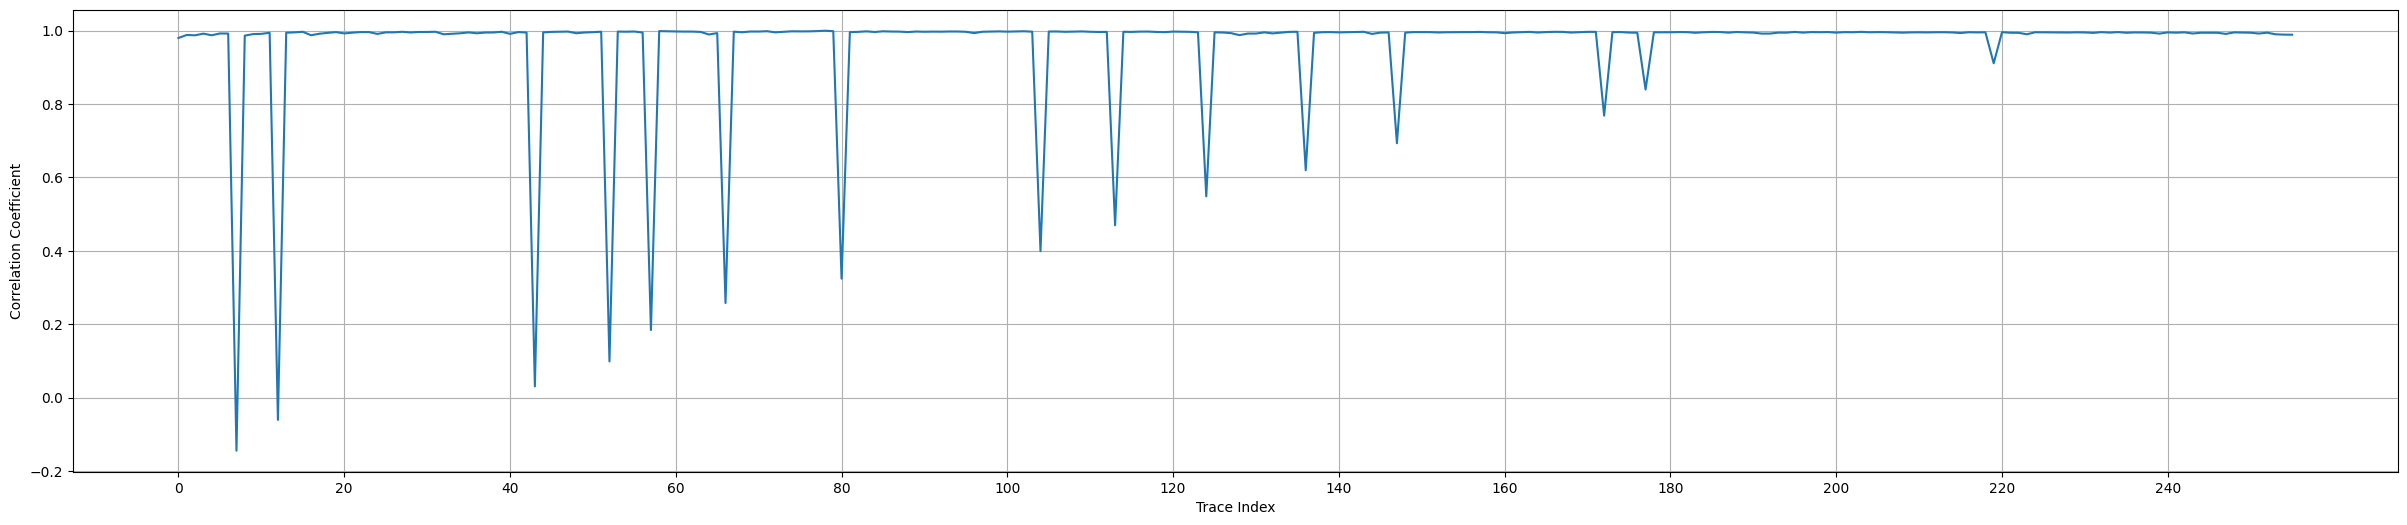

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

try:
    input_file = 'power_traces_and_plaintexts.npz'
    data = np.load(input_file)
except FileNotFoundError:
    print(f"Error: File not found at '{input_file}'.")
    print("Make sure you run the capture and save script first.")
    exit()

loaded_traces = data['power_traces']
loaded_plaintexts = data['plaintexts']

print(f"✅ Data loaded successfully from '{input_file}'.")
print(f"Found {len(loaded_traces)} traces to visualize.")
cropped_traces = []
for i in range(256): # len(loaded_traces)
    trace = loaded_traces[i]
    cropped_traces.append(trace[3950:4150])

cropped_traces = np.array(cropped_traces)
guessed_dict = {}

for i in range(0,18):

    random_index = random.randint(0, len(cropped_traces) - 1)

    random_trace = cropped_traces[random_index]
    correlations = [pearsonr(random_trace, trace)[0] for trace in cropped_traces]
    correlations = np.array(correlations)

    mean = np.mean(correlations)

    if mean < 0.5:
        continue

    sorted_indices = np.argsort(correlations)
    sorted_correlations = np.array(correlations)[sorted_indices]
    # print("Sorted correlations:", sorted_correlations)
    print("Original indices in sorted order:", sorted_indices)

    guess_array_unsorted = sorted_indices[:15]
    guess_array = np.sort(guess_array_unsorted)
    print("Top 16 guesses for the character:", guess_array)

    if ",".join(map(str, guess_array)) not in guessed_dict.keys():
        guessed_dict[",".join(map(str, guess_array))] = 1
    else:
        print(",".join(map(str, guess_array)))

        plt.figure(figsize=(30, 6))
        plt.plot(correlations)
        plt.xticks(ticks=range(0, 256, 20), labels=range(0, 256, 20))
        # plt.title("Pearson Correlation Coefficients with a Random Trace")
        plt.xlabel("Trace Index")
        plt.ylabel("Correlation Coefficient")
        plt.grid(True)
        plt.show()

        break


In [ ]:
target.simpleserial_write('a', bytearray(list(guess_array)))
resp = target.simpleserial_read('r', 20)
if resp is not None:
    print("a: ", resp)
    
#check number of queries
target.simpleserial_write('q', b"0")
resp = target.simpleserial_read('r', 4)
if resp is not None:
    print(f"Number of Queries (cumulative): {int.from_bytes(resp, byteorder='little', signed=False)}") #number of queries since powerup     

a:  bytearray(b'ss1{y0u_g0t_it_br0!}')
Number of Queries (cumulative): 259


## Sorters Song 2

## Capturing traces

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random
import string
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

# Number of power traces
num_traces = 256 *256

# Define an array to store all the power traces
power_traces = []

target.simpleserial_write('x', b'')
resp = target.simpleserial_read('r', 1)
if resp is not None:
    print("x: ", resp)
    
num = 1
pos=1
target.simpleserial_write('p', bytearray([1, num&0xff, 0, pos]))
resp = target.simpleserial_read('r', 2)
if resp is not None:
    print("p: ", int.from_bytes(resp, byteorder='little', signed=False))
    
target.simpleserial_write('c', b'')
resp = target.simpleserial_read('r', 1)
if resp is not None:
    print("c: ", resp)


power_traces = []
plaintexts = []

for i in range (0, num_traces):

    # Define array with 15 random unit8 values
    # plaintext = np.random.randint(0, 256, size=15, dtype=np.uint8).tolist()
    plaintext = [i%256, i//256] * 15
    print("Plaintext:", plaintext)

    # Arm the Chipwhisper
    scope.arm()

    target.simpleserial_write('b', bytearray(plaintext))

    # Capture the power trace
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')

    resp = target.simpleserial_read('r', 20)
    if resp is not None:
        print("a: ", resp)

    # Read the power trace from the ChipWhisperer Nano
    power_trace = scope.get_last_trace()

    # Append the power trace to the list of power traces
    power_traces.append(power_trace)
    plaintexts.append(plaintext)

    # Store power traces and plaintexts in a .npz file
    if (((i+1) % 256) == 0 and i>0):
        np.savez('power_traces_and_plaintexts_{}.npz'.format(i // 256), power_traces=np.array(power_traces), plaintexts=np.array(plaintexts))
        power_traces = []
        plaintexts = []

In [ ]:
cropped_traces = []
loaded_plaintexts = []
for i in range(1, 257):
    try:
        input_file = f'power_traces_and_plaintexts_{i}.npz'
        data = np.load(input_file)
    except FileNotFoundError:
        print(f"Error: File not found at '{input_file}'.")

    loaded_traces = data['power_traces']
    loaded_plaintexts = data['plaintexts']

    if i == 1:
        cropped_traces = loaded_traces[:,3000:5000]
        loaded_plaintexts = loaded_plaintexts
    else:
        cropped_traces = np.concatenate((cropped_traces, loaded_traces[:,3000:5000]), axis=0)
        loaded_plaintexts = np.concatenate((loaded_plaintexts, loaded_plaintexts), axis=0)

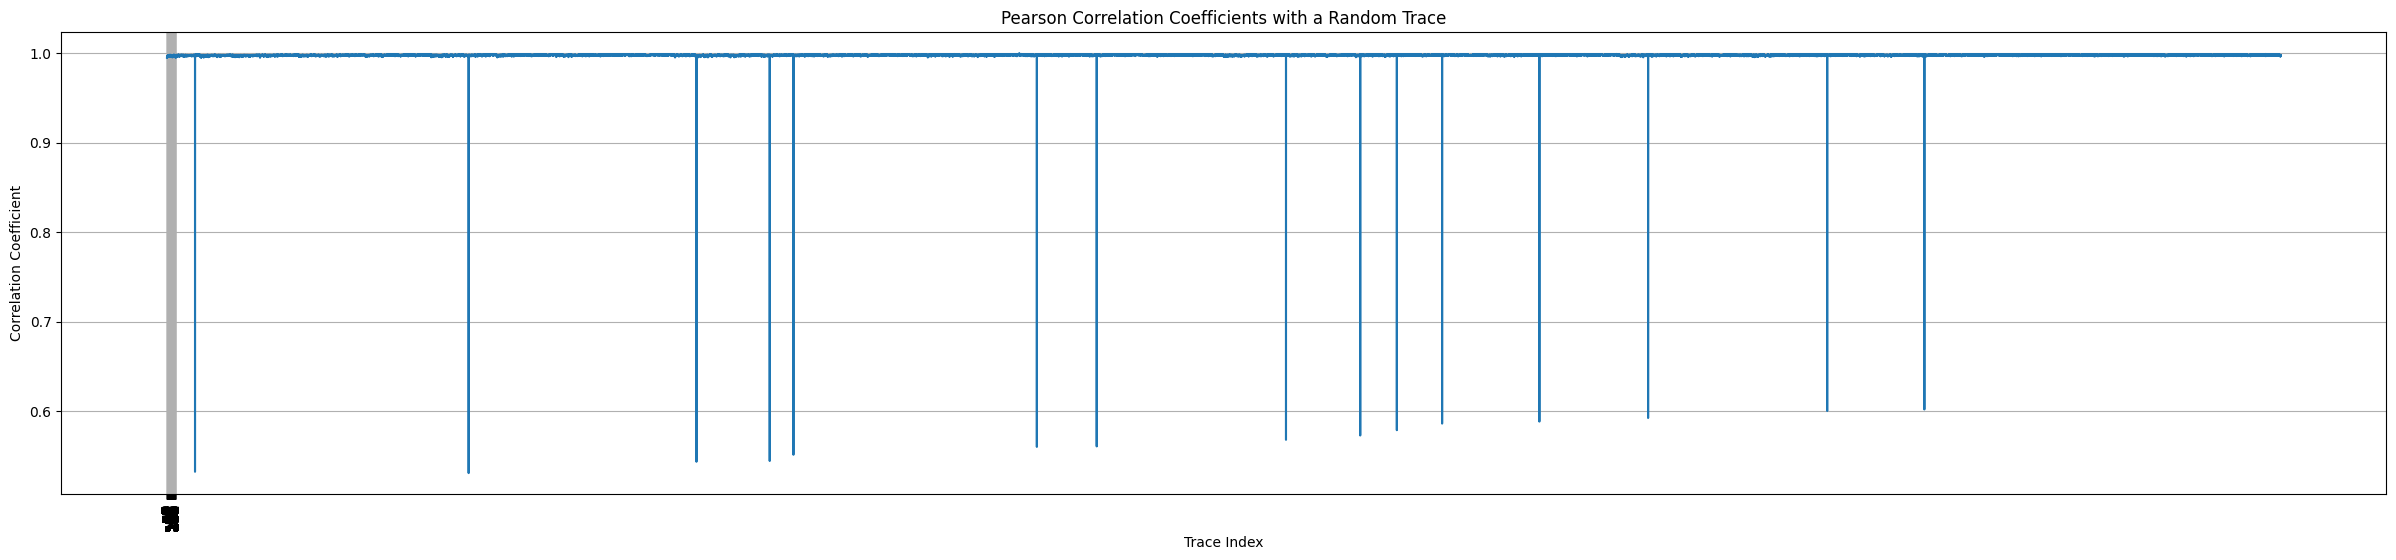

In [ ]:
flag_length = 15

for i in range(0, flag_length+1):

    random_index = random.randint(0, len(cropped_traces) - 1)

    random_trace = cropped_traces[random_index]

    correlations = [pearsonr(random_trace, trace_temp)[0] for trace_temp in cropped_traces]
    correlations = np.array(correlations)

    mean = np.mean(correlations)

    plt.figure(figsize=(30, 6))
    plt.plot(correlations)

    plt.xticks(ticks=range(0, 256), labels=range(0, 256), rotation=90)
    plt.title("Pearson Correlation Coefficients with a Random Trace")
    plt.xlabel("Trace Index")
    plt.ylabel("Correlation Coefficient")
    plt.grid(True)
    plt.show()

    if mean < 0.5:
        continue
    else:
        break

In [ ]:
from scipy.signal import find_peaks

def zncc_1d(signal: np.ndarray, template: np.ndarray):
    """
    Z-normalized cross-correlation (1D) producing 'valid' positions only.
    Returns an array of length len(signal) - len(template) + 1 with scores in [-1, 1].
    """
    s = np.asarray(signal, dtype=float)
    t = np.asarray(template, dtype=float)
    M = len(t)
    if M > len(s):
        raise ValueError("Template must be shorter than or equal to the signal.")

    # template stats
    t_mean = t.mean()
    t_centered = t - t_mean
    t_std = t_centered.std(ddof=0)
    if t_std == 0:
        raise ValueError("Template has zero variance; ZNCC is undefined.")

    # rolling sums over the signal using convolution with a ones window
    w = np.ones(M, dtype=float)
    sum_s  = np.convolve(s, w, mode='valid')
    sum_s2 = np.convolve(s*s, w, mode='valid')

    mean_s = sum_s / M
    var_s  = (sum_s2 / M) - (mean_s**2)
    var_s[var_s < 0] = 0.0                         # numerical guard
    std_s  = np.sqrt(var_s)
    std_s[std_s == 0] = np.inf                     # avoid div-by-zero => score 0

    # numerator: sum( (s_win - mean_s)* (t - mean_t) )
    # = sum(s_win * (t - mean_t)) - M*mean_s*0  (since sum(t - mean_t) = 0)
    # compute via conv with reversed centered template
    num = np.convolve(s, t_centered[::-1], mode='valid')

    # denominator: sqrt( M*var_s ) * sqrt( M*var_t ) = M * std_s * t_std
    den = M * std_s * t_std

    zncc = num / den
    zncc[np.isinf(zncc)] = 0.0
    zncc = np.clip(zncc, -1.0, 1.0)
    return zncc

def find_template_matches(signal, template, threshold=0.8, min_separation=None):
    """
    Returns (match_indices, scores, zncc_curve)
    match_indices are start positions in 'signal' where template matches.
    """
    zncc = zncc_1d(signal, template)
    M = len(template)
    if min_separation is None:
        min_separation = max(1, M // 2)  # avoid overlapping duplicate hits

    # pick local maxima above threshold
    peaks, props = find_peaks(zncc, height=threshold, distance=min_separation)
    return peaks, props["peak_heights"], zncc

# If starting point identification
min_start = 5000
if_template = cropped_traces[0][965:983]

for trace in cropped_traces:
    long_trace = trace
    template = if_template

    # Find matches
    idxs, scores, zncc = find_template_matches(long_trace, template, threshold=0.7)

    # print("Match starts:", idxs.tolist())
    # print("Match scores:", [round(s, 3) for s in scores])

    if (min_start > idxs.tolist()[0]):
        min_start = idxs.tolist()[0]

print(min_start)

452


In [ ]:
threshold = 0.9

sel_array = np.where(correlations < threshold)[0]
# sel_characters = [loaded_plaintexts[index] for index in sel_array]
print(sel_array)

if_check_pos = np.array([(1)+ 18*(i) for i in range(flag_length)])
print(if_check_pos)

correct_flag = [sel_array]* flag_length

for sel_index in sel_array:
    long_trace = cropped_traces[sel_index][(min_start-1):min_start+ 18*(flag_length + 2)]
    template = if_template

    # Find matches
    idxs, scores, zncc = find_template_matches(long_trace, template, threshold=0.75)

    match_start = np.array(idxs.tolist())

    limit = flag_length - len(sel_array) + 1                      # distance limit

    # Compute pairwise absolute differences
    diff = np.abs(if_check_pos[:, None] - match_start[None, :])

    # For each element in a, check if ALL distances > limit
    mask = np.all(diff > limit, axis=1)

    # Get elements in a that are NOT within 'limit' of any number in b
    result = if_check_pos[mask]

    # print("Match starts:", idxs.tolist())
    # print("Match scores:", [round(s, 3) for s in scores])

    # # Plot correlation + locations on the trace
    plt.figure(figsize=(10, 6))

    # # Correlation curve
    plt.subplot(2,1,1)
    plt.plot(zncc)
    plt.axhline(0.75, linestyle="--")
    for i in idxs:
        plt.axvline(i, linestyle=":")
    plt.title("ZNCC (template vs. signal)")

    # # Signal with match markers
    plt.subplot(2,1,2)
    plt.plot(long_trace)
    for i in idxs:
        # show the span of the match
        plt.axvspan(i, i+len(template), alpha=0.2)
    plt.title("Signal with matched regions highlighted")
    plt.tight_layout()
    plt.show()

    # print("Elements not within limit :", result)

    miss_index = [np.where(if_check_pos == x)[0][0] for x in result if x in if_check_pos]

    for miss in miss_index:
        correct_flag[miss] = sel_index

print(correct_flag)



In [83]:
target.simpleserial_write('b', bytearray([102, 3, 138, 36, 34, 64, 1, 73, 225, 75, 92, 105, 156, 112, 137, 135, 135, 144, 246, 148, 114, 154, 58, 166, 101, 179, 22, 201, 219, 212]))
resp = target.simpleserial_read('r', 20)
if resp is not None:
    print("b: ", resp)

#check number of queries
target.simpleserial_write('q', b"0")
resp = target.simpleserial_read('r', 4)
if resp is not None:
    print(f"Number of Queries (cumulative): {int.from_bytes(resp, byteorder='little', signed=False)}") #number of queries since powerup
    

b:  bytearray(b'ss2{!AEGILOPS_chimps')
Number of Queries (cumulative): 2
